In [82]:
import os, sys
import copy
sys.path.append("../")

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.lines import Line2D
import matplotlib
from scipy.interpolate import interp1d
from tqdm import *

from twentyone.twentyone import TwentyOne, TwentyOneSolver
from twentyone.units import *

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
from plot_params import params
pylab.rcParams.update(params)

cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

## 1. Basic example

In [10]:
to = TwentyOne(z_min=10., z_max=500., f_star_L=0.01, f_star_X=0.01, T_vir_cut=2e4 * Kelv)

In [19]:
z_max = 150.
z_min = 11.
z_21_ary = np.logspace(np.log10(z_min), np.log10(z_max), 1000)[:: -1]

In [16]:
T_gamma_SM = lambda z: to.T_CMB(z)
to_SM_solve = TwentyOneSolver(T_gamma=T_gamma_SM, to=to, z_ary=z_21_ary)
to_SM_solve.solve()

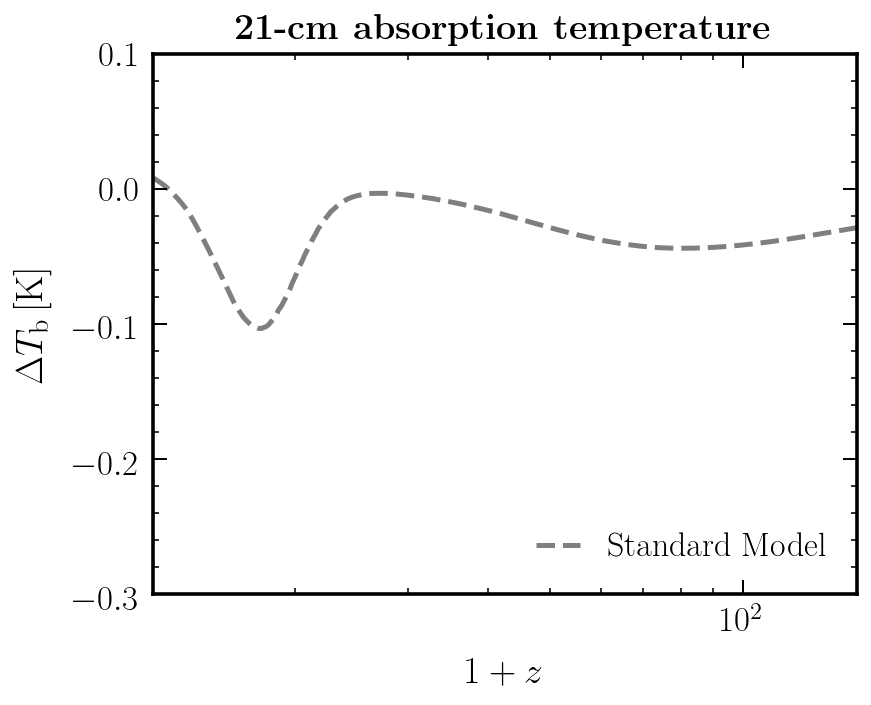

In [173]:
fig, ax = plt.subplots()

plt.plot(1 + to_SM_solve.z_ary, to_SM_solve.delta_T_b_ary, label='Standard Model', color='k', alpha=0.5, ls='--')

plt.xlabel("$1 + z$")
plt.ylabel("$\Delta T_{\mathrm b}\,\mathrm{[K]}$")
plt.title(r"\bf{21-cm absorption temperature}")

plt.legend(loc='lower right', handlelength=1.3)

plt.xlim(np.min(1 + to_SM_solve.z_ary), np.max(1 + to_SM_solve.z_ary))
plt.ylim(-0.3, 0.1)

plt.xscale("log")

plt.tight_layout()



## 2. Changing astrophysical parameters

In [24]:
to_1 = copy.copy(to) 
to_1.mod_f_star(f_star_X=0.04, f_star_L=0.04)

to_SM_1_solve = TwentyOneSolver(T_gamma=T_gamma_SM, to=to_1, z_ary=z_21_ary)
to_SM_1_solve.solve()

In [36]:
to_2 = copy.copy(to)
to_2.mod_f_star(T_vir_cut=5e4 * Kelv)

to_SM_2_solve = TwentyOneSolver(T_gamma=T_gamma_SM, to=to_2, z_ary=z_21_ary)
to_SM_2_solve.solve()

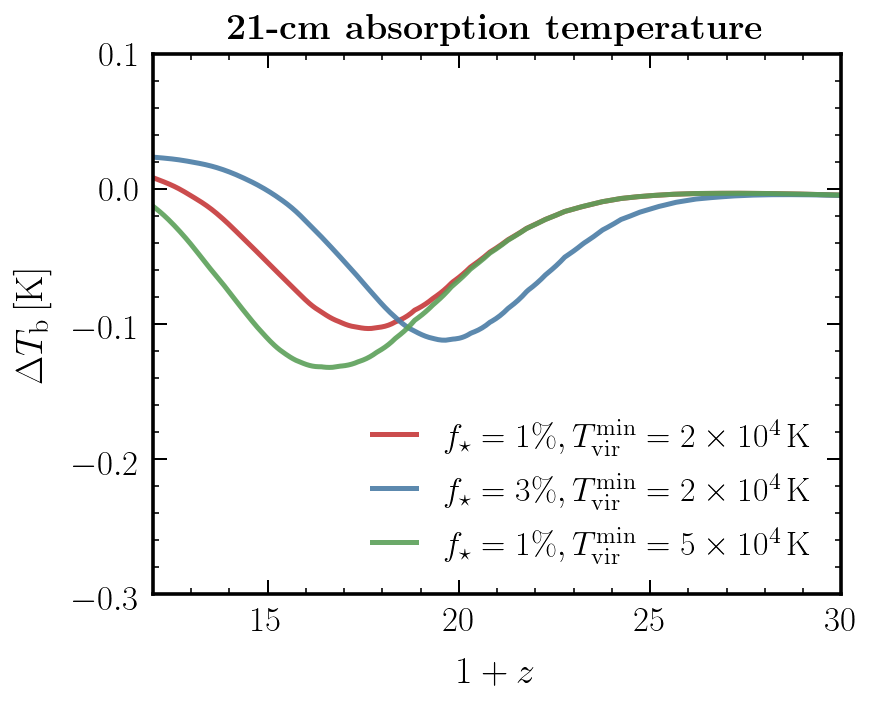

In [180]:
fig, ax = plt.subplots()

plt.plot(1 + to_SM_solve.z_ary, to_SM_solve.delta_T_b_ary, label=r'$f_\star = 1\%, T_\mathrm{vir}^\mathrm{min} = 2\times10^4$\,K')
plt.plot(1 + to_SM_1_solve.z_ary, to_SM_1_solve.delta_T_b_ary, label=r'$f_\star = 3\%, T_\mathrm{vir}^\mathrm{min} = 2\times10^4$\,K')
plt.plot(1 + to_SM_2_solve.z_ary, to_SM_2_solve.delta_T_b_ary, label=r'$f_\star = 1\%, T_\mathrm{vir}^\mathrm{min} = 5\times10^4$\,K')

plt.xlabel("$1 + z$")
plt.ylabel("$\Delta T_{\mathrm b}\,\mathrm{[K]}$")
plt.title(r"\bf{21-cm absorption temperature}")

plt.legend(loc='lower right', handlelength=1.3)

plt.xlim(np.min(1 + to_SM_solve.z_ary), 30)
plt.ylim(-0.3, 0.1)

plt.tight_layout()

## 3. Non-standard temperature evolution

In [153]:
def T_CMB_powerlaw(z, A_r=5.7, beta=-2.6, omega_base=2 * np.pi * 78 * 1e6 / Sec / eV):
    """ Powerlaw spectrum according to Eq. (7) of 1902.02438
    """
    return to.T_CMB_0 * (1 + A_r * (omega_21 / eV / (1 + z) / omega_base) ** beta) * (1 + z)

In [132]:
from tqdm.notebook import tqdm

f_ary = np.logspace(-3, 0, 4)

delta_T_b_mod_ary = []

for f in tqdm(f_ary):
    T_CMB_mod = interp1d(z_21_ary, T_CMB_powerlaw(z_21_ary, f * A_r, beta))
    to_mod_solve = TwentyOneSolver(T_gamma=T_CMB_mod, to=to, z_ary=z_21_ary)
    to_mod_solve.solve()
    delta_T_b_mod_ary.append(to_mod_solve.delta_T_b_ary)

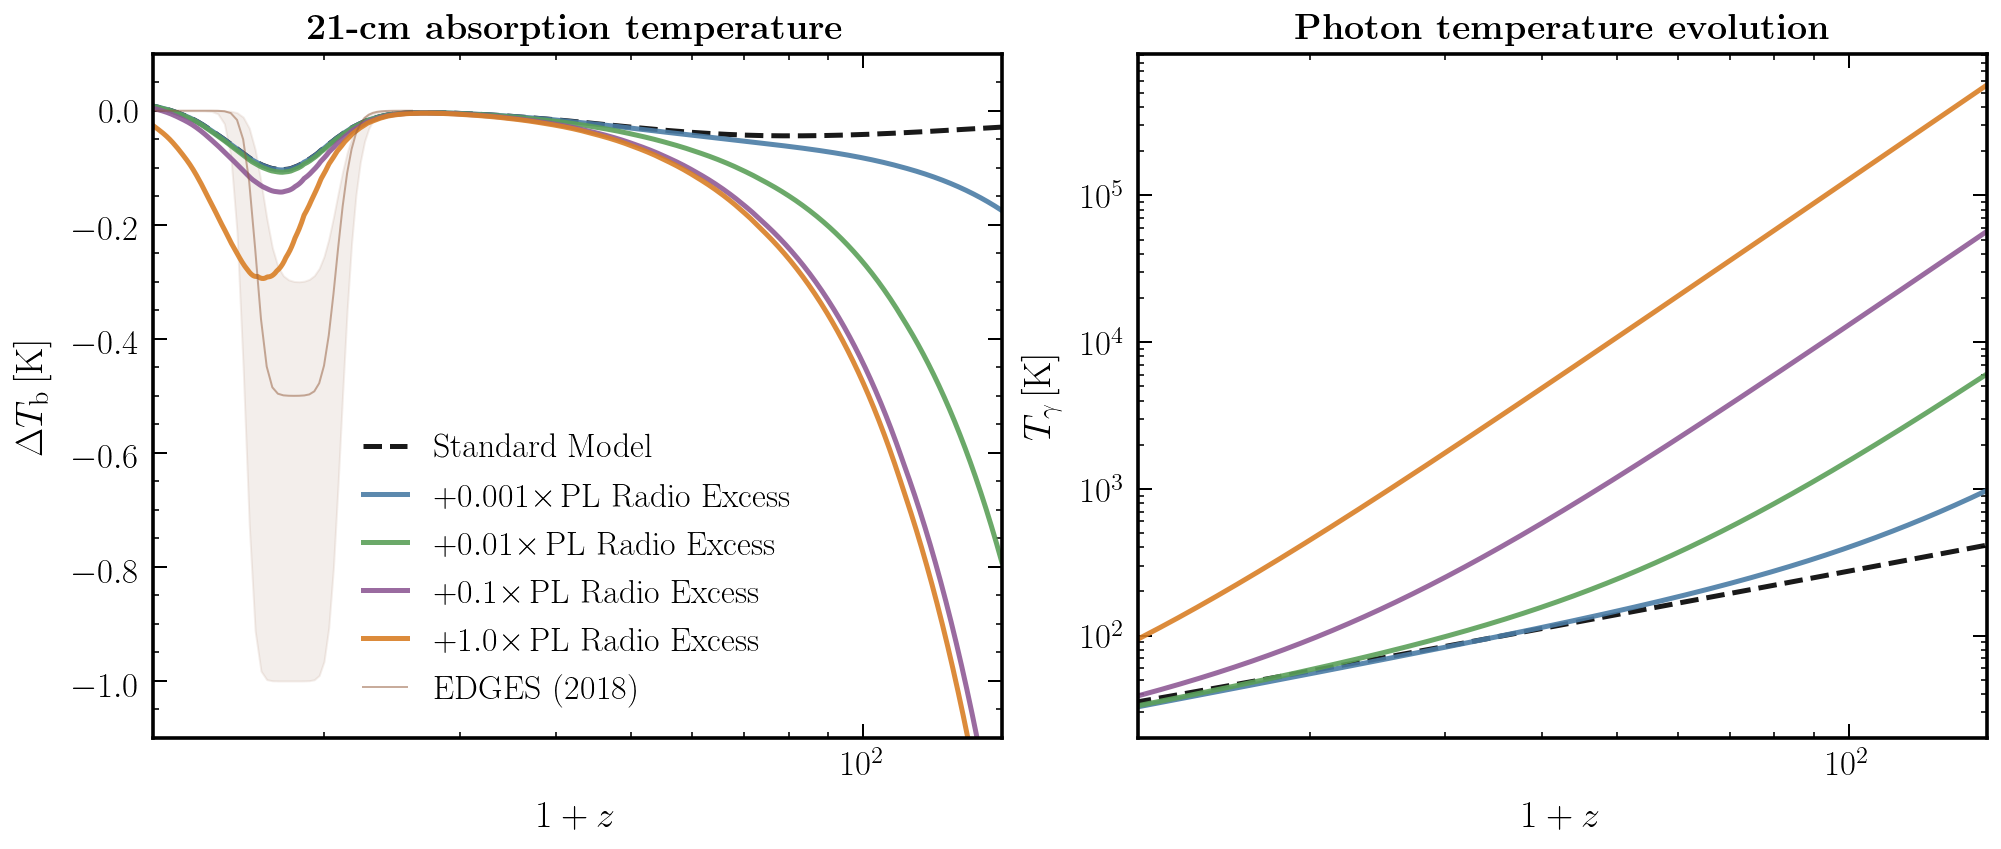

In [188]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

## 21-cm absorption temperature plot

ax[0].plot(1 + to_SM_solve.z_ary, to_SM_solve.delta_T_b_ary, label='Standard Model', color='k',ls='--')

for i in range(len(f_ary)):
    ax[0].plot(1 + to_mod_solve.z_ary, delta_T_b_mod_ary[i], label=r'$+' + str(f_ary[i]) + r"\times$\,PL Radio Excess")

ax[0].set_xlabel(r"$1 + z$")
ax[0].set_ylabel(r"$\Delta T_{\mathrm b}\,\mathrm{[K]}$")
ax[0].set_title(r"\bf{21-cm absorption temperature}")

ax[0].set_xlim(np.min(1 + to_SM_solve.z_ary), np.max(1 + to_SM_solve.z_ary))
ax[0].set_ylim(-1.1, 0.1)

ax[0].set_xscale("log")

from twentyone.edges import EDGES_fit
z_21_edges_ary = np.linspace(11, 25)
edges_mid, edges_lo, edges_hi = EDGES_fit(z_21_edges_ary).T21_fit

ax[0].plot(1 + z_21_edges_ary, edges_mid, color=cols_default[-4], alpha=0.5, lw=1, label="EDGES (2018)")
ax[0].fill_between(1 + z_21_edges_ary, edges_lo, edges_hi, alpha=0.1, color=cols_default[-4])

ax[0].legend(loc='lower center', handlelength=1.3)

## Photon temperature plot

ax[1].plot(z_21_ary, to.T_CMB(z_21_ary), label='Standard Model', color='k',ls='--')

for f in f_ary:
    T_CMB_mod = interp1d(z_21_ary, T_CMB_powerlaw(z_21_ary, f * A_r, beta))
    ax[1].plot(1 + z_21_ary, T_CMB_mod(z_21_ary))
    ax[1].set_xscale("log")
    ax[1].set_yscale("log")

ax[1].set_xlabel(r"$1 + z$")
ax[1].set_ylabel(r"$T_\gamma$\,[K]")
ax[1].set_title(r"\bf{Photon temperature evolution}")

ax[1].set_xlim(np.min(1 + to_SM_solve.z_ary), np.max(1 + to_SM_solve.z_ary))

plt.tight_layout()